## Parameter Estimation Workflow
A single optimization problem run many times can reveal more information that running just the once. Pycotools is geared towards running and analysing multiple parameter estimations

In [2]:
%matplotlib inline
import os, glob, pandas
try:
    ## if using the Python 3 version
    from pycotools3 import viz, model, misc, tasks, models
except ImportError:
    ## fall back on the python 2 version 
    from pycotools import viz, model, misc, tasks, models

### Build Example Model
Here we use the same model as in the QuickStart tutorial.

In [8]:
working_directory = r'/home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir'
copasi_file = os.path.join(working_directory, 'MichaelisMenten.cps')

if os.path.isfile(copasi_file):
    os.remove(copasi_file)

    
kf = 0.01
kb = 0.1
kcat = 0.05
with model.Build(copasi_file) as m:
    m.name = 'Michaelis-Menten'
    m.add('compartment', name='Cell')
    
    m.add('metabolite', name='P', concentration=0)
    m.add('metabolite', name='S', concentration=30)
    m.add('metabolite', name='E', concentration=10)
    m.add('metabolite', name='ES', concentration=0)
    
    m.add('reaction', name='S bind E', expression='S + E -> ES', rate_law='kf*S*E',
          parameter_values={'kf': kf})
    
    m.add('reaction', name='S unbind E', expression='ES -> S + E', rate_law='kb*ES',
         parameter_values={'kb': kb})

    m.add('reaction', name='ES produce P', expression='ES -> P + E', rate_law='kcat*ES', 
          parameter_values={'kcat': kcat})
    
michaelis_menten = model.Model(copasi_file)
michaelis_menten

Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)

#### Simulate Time Course

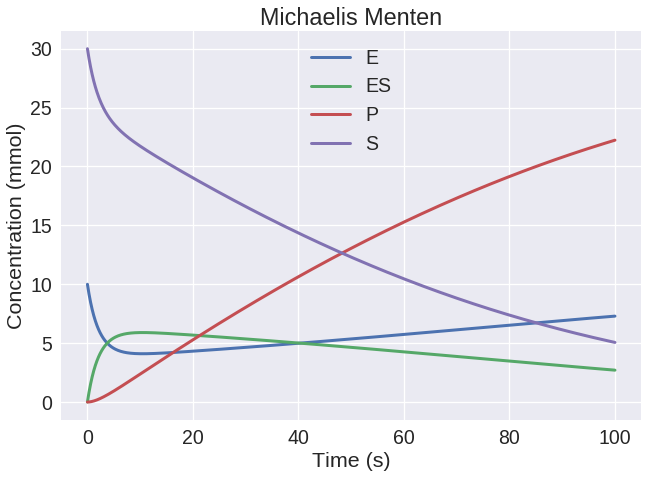

In [9]:
tc = tasks.TimeCourse(michaelis_menten, end=100, intervals=100, step_size=0.1)
viz.PlotTimeCourse(tc, separate=False, title='Michaelis Menten')

#### Generate Synthetic Data

In [10]:
report= 'parameter_estimation_synthetic_data.txt'
TC=tasks.TimeCourse(
    michaelis_menten, start=0, end=100, intervals=10, step_size=10, report_name=report
)

pandas.read_csv(TC.report_name,sep='\t').head()

,Time,[E],[ES],[P],[S]
0,0,10.00000,0.00000,0.00000,30.0000
1,10,4.10191,5.89809,2.37588,21.7260
2,20,4.31725,5.68275,5.28367,19.0336
3,30,4.64091,5.35909,8.04533,16.5956
4,40,4.98869,5.01131,10.63880,14.3499


#### Format synthetic data
Copasi by default outputs outputs specie headers which do not exactly correspond to model components. Pycotools `misc.correct_copasi_output

In [11]:
misc.correct_copasi_timecourse_headers(TC.report_name)

,Time,E,ES,P,S
0,0,10.00000,0.00000,0.00000,30.00000
1,10,4.10191,5.89809,2.37588,21.72600
2,20,4.31725,5.68275,5.28367,19.03360
3,30,4.64091,5.35909,8.04533,16.59560
4,40,4.98869,5.01131,10.63880,14.34990
5,50,5.35620,4.64380,13.05330,12.30290
6,60,5.73910,4.26090,15.28000,10.45910
7,70,6.13163,3.86837,17.31260,8.81900
8,80,6.52677,3.47323,19.14800,7.37878
9,90,6.91678,3.08322,20.78670,6.13005


### Run parameter estimations
Here we opt to estimate everything.

In [60]:
fit1=tasks.MultiParameterEstimation(
    michaelis_menten, TC.report_name, copy_number=3, pe_number=20, 
    lower_bound=1e-3, upper_bound=5e3, 
    results_directory='fit1',
    method='genetic_algorithm_sr', population_size=150, number_of_generations=400,
    overwrite_config_file=True
)
    
fit1.write_config_file()
fit1.setup()
fit1.run()

pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)


### Exploratory data analysis on parameter estimation data 

#### Evaluate the performance of the optimization algorithm

##### Likelihood-Ranks Plot


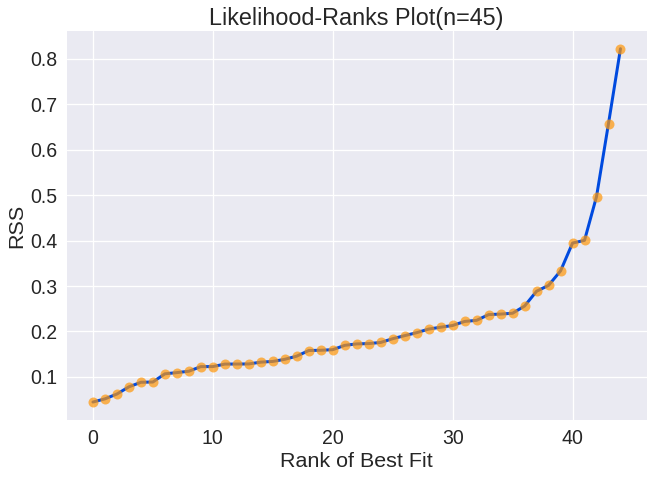

In [61]:
viz.LikelihoodRanks(fit1)

Most parameter sets (below rank of 50) have similar RSS values. However the smooth curve indicates the iterations are likely *not* finding the minima. 

### Distributions of parameters

#### Boxplots

/home/b3053674/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


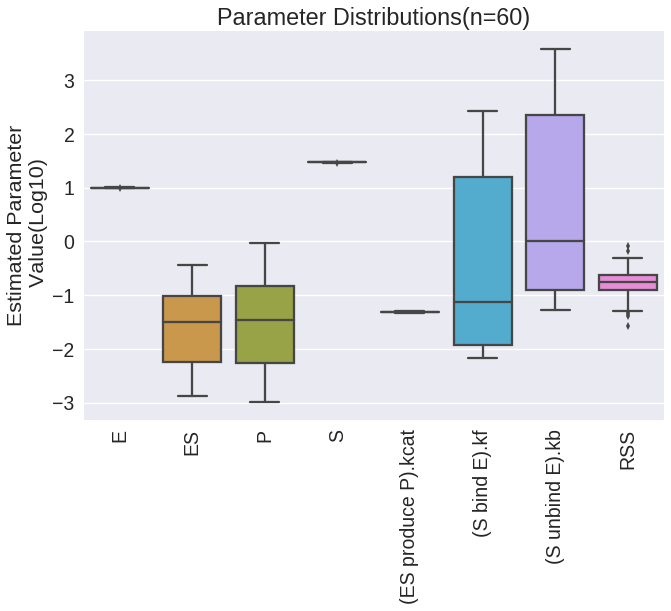

In [14]:
viz.Boxplots(fit1, num_per_plot=8, log10=True)

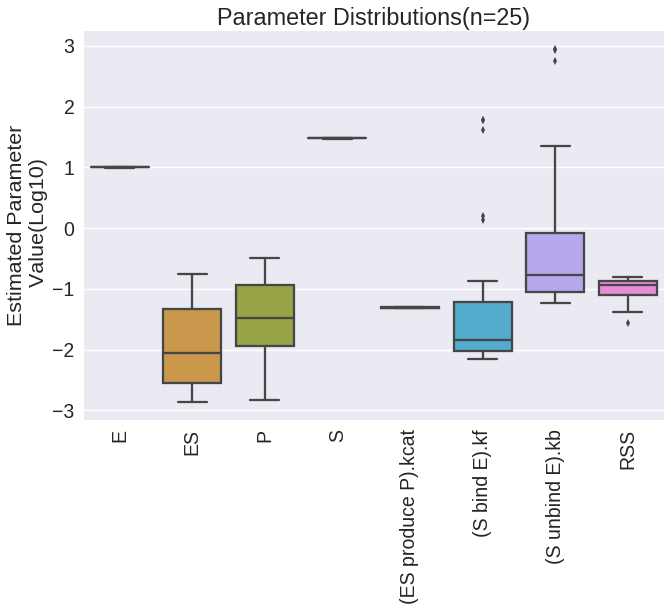

In [15]:
viz.Boxplots(fit1, num_per_plot=8, log10=True, truncate_mode='ranks', theta=range(25))

#### Histograms

pycotools.viz:INFO:2357:    plotting histograms


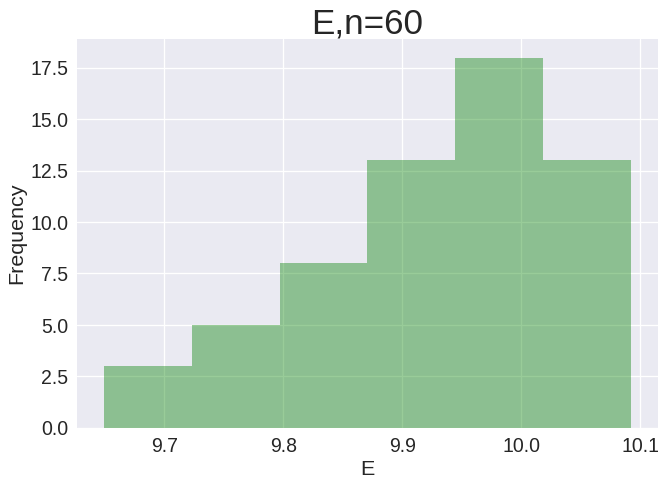

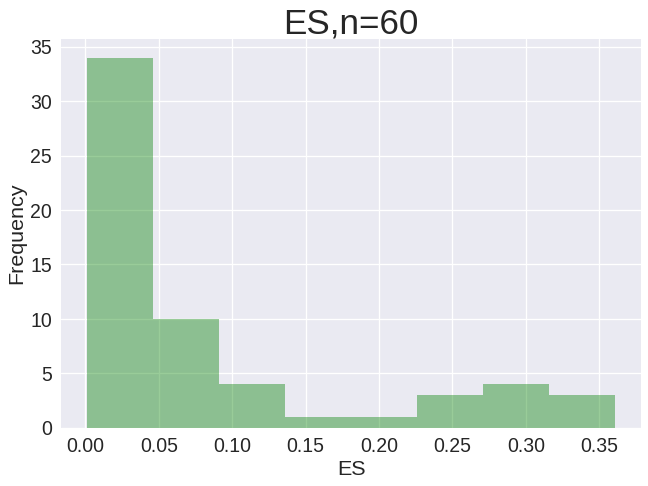

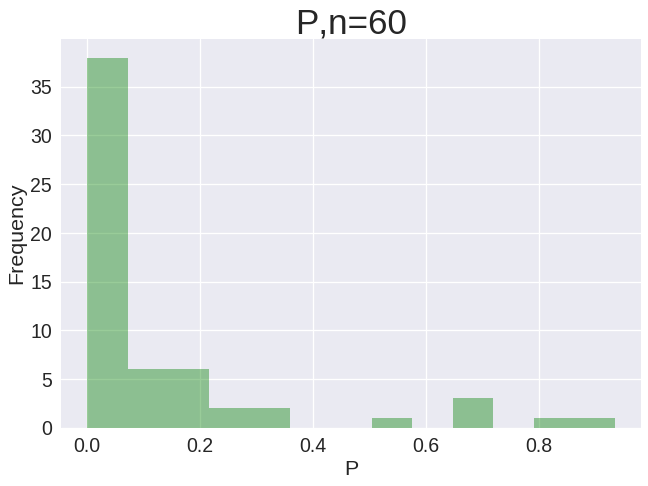

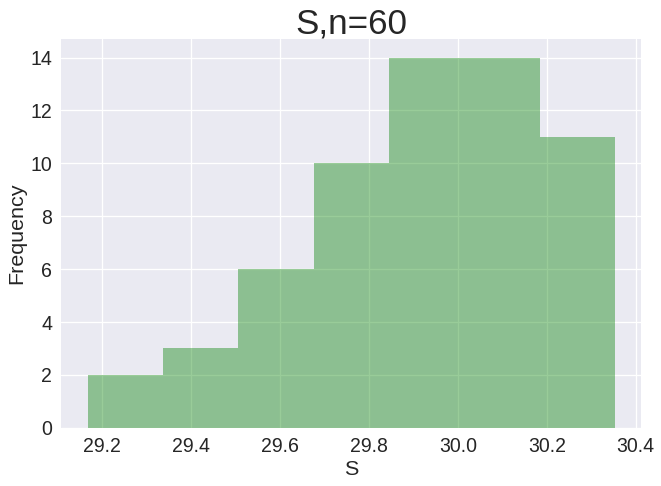

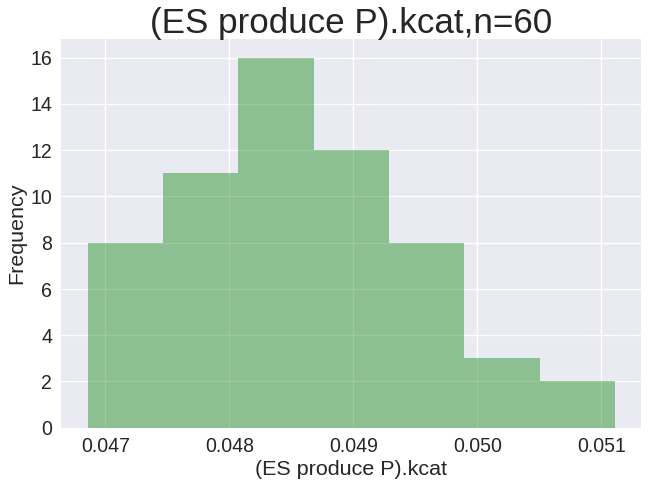

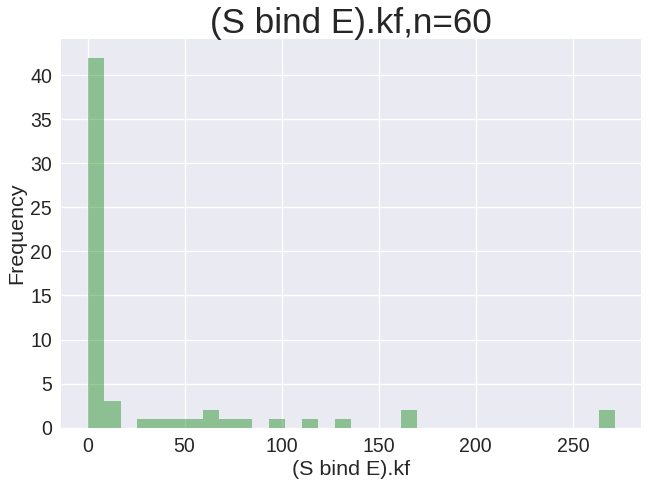

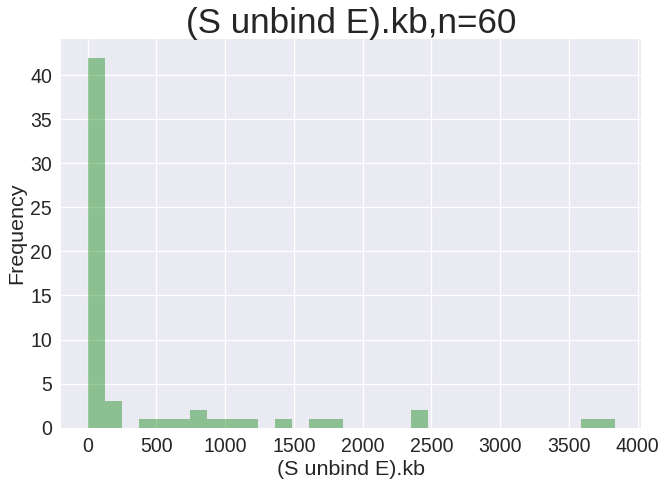

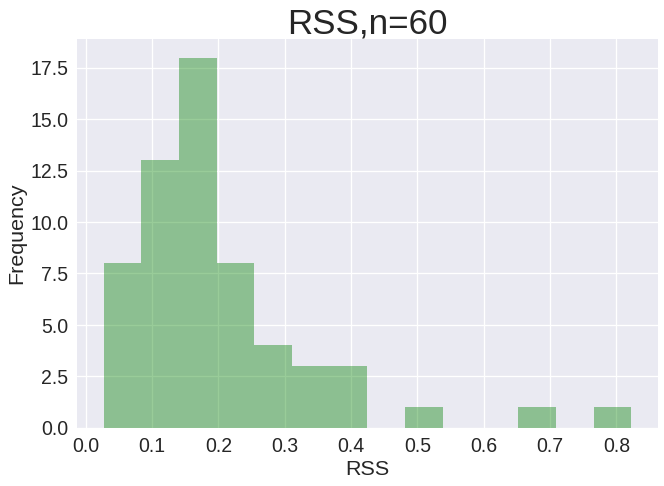

In [16]:
viz.Histograms(fit1)

### Correlations

#### Pearsons Correlations

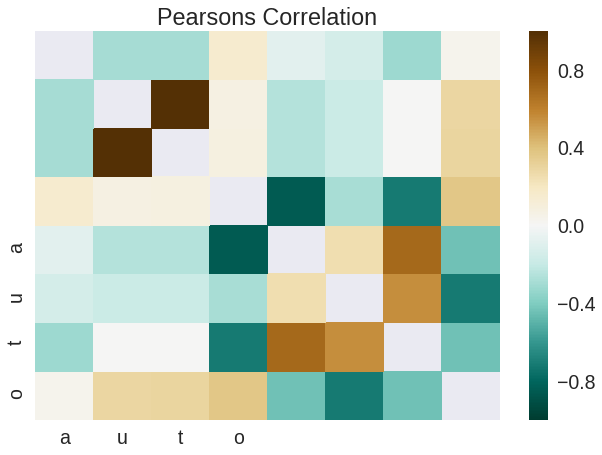

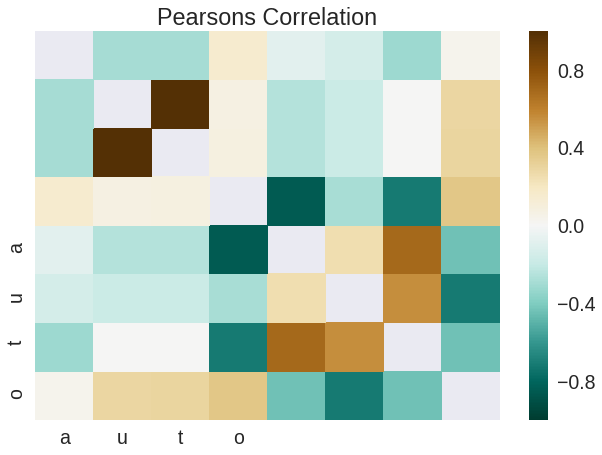

In [17]:
PC = viz.PearsonsCorrelation(fit1, show=True)
PC.heatmap()

In [18]:
PC.pearsons

,(ES produce P).kcat,(S bind E).kf,(S unbind E).kb,E,ES,P,RSS,S
(ES produce P).kcat,NaN,-0.294375,-0.295029,0.155739,-0.078161,-0.143453,-0.314422,0.035497
(S bind E).kf,-0.294375,NaN,0.999721,0.076606,-0.252946,-0.179869,0.003754,0.296111
(S unbind E).kb,-0.295029,0.999721,NaN,0.079273,-0.254292,-0.180216,0.003792,0.300092
E,0.155739,0.076606,0.079273,NaN,-0.843779,-0.288352,-0.713269,0.368030
ES,-0.078161,-0.252946,-0.254292,-0.843779,NaN,0.251914,0.697290,-0.437662
P,-0.143453,-0.179869,-0.180216,-0.288352,0.251914,NaN,0.561175,-0.712226
RSS,-0.314422,0.003754,0.003792,-0.713269,0.697290,0.561175,NaN,-0.442341
S,0.035497,0.296111,0.300092,0.368030,-0.437662,-0.712226,-0.442341,NaN


In [19]:
PC.p_val

,(ES produce P).kcat,(S bind E).kf,(S unbind E).kb,E,ES,P,RSS,S
(ES produce P).kcat,NaN,0.0224246346626,0.0221136784201,0.234738358265,0.552775102365,0.274184079634,0.0144182370407,0.787728910554
(S bind E).kf,0.0224246346626,NaN,4.87081168919e-96,0.560729997361,0.0511845079626,0.169071242242,0.97728861579,0.0216076372077
(S unbind E).kb,0.0221136784201,4.87081168919e-96,NaN,0.547122456084,0.0499182623186,0.168235569308,0.977057534401,0.0198285092309
E,0.234738358265,0.560729997361,0.547122456084,NaN,2.58964271967e-17,0.0254652267813,1.60717092154e-10,0.00381495491011
ES,0.552775102365,0.0511845079626,0.0499182623186,2.58964271967e-17,NaN,0.0521719848167,6.0296087087e-10,0.000470580888035
P,0.274184079634,0.169071242242,0.168235569308,0.0254652267813,0.0521719848167,NaN,3.09911230344e-06,1.7568461258e-10
RSS,0.0144182370407,0.97728861579,0.977057534401,1.60717092154e-10,6.0296087087e-10,3.09911230344e-06,NaN,0.000402072968146
S,0.787728910554,0.0216076372077,0.0198285092309,0.00381495491011,0.000470580888035,1.7568461258e-10,0.000402072968146,NaN


It appears that some of these parameters are statistically linearly correlated:

  * (S bind E).kf and (S unbind E).kb
  * E and ES
 

### Scatters
Now we have an idea of which pairs of parameters are linearly correlated we can target them with scatter plots. 

pycotools.viz:INFO:2570:    Plotting "S" Vs "E"


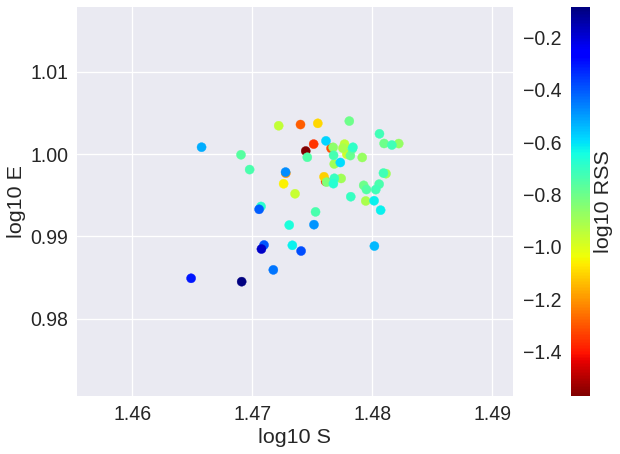

In [20]:
viz.Scatters(fit1, x=['S'], y=['E'], log10=True)

Remember to look at the scale of the axes. 

pycotools.viz:INFO:2570:    Plotting "(S unbind E).kb" Vs "(S bind E).kf"


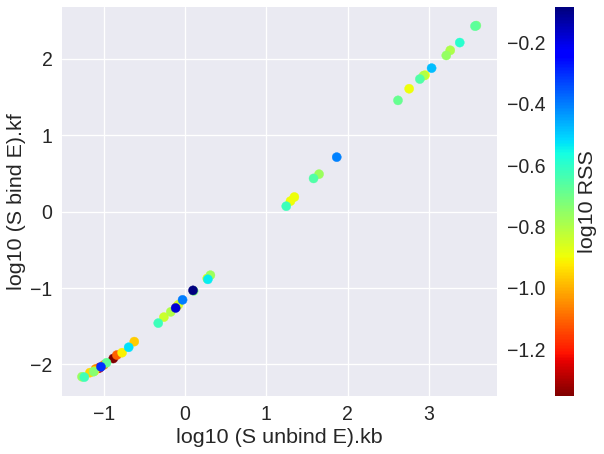

In [66]:
viz.Scatters(fit1, x=['(S unbind E).kb'], y=['(S bind E).kf'], log10=True)

### Time course Ensemble

pycotools.viz:DEBUG:1390:    tpe self.cls parse --> MultiParameterEstimation(copy_number="3", pe_number="20", method="genetic_algorithm_sr")
pycotools.viz:INFO:1517:    Plotting "E"
pycotools.viz:INFO:1517:    Plotting "ES"
pycotools.viz:INFO:1517:    Plotting "P"
pycotools.viz:INFO:1517:    Plotting "S"


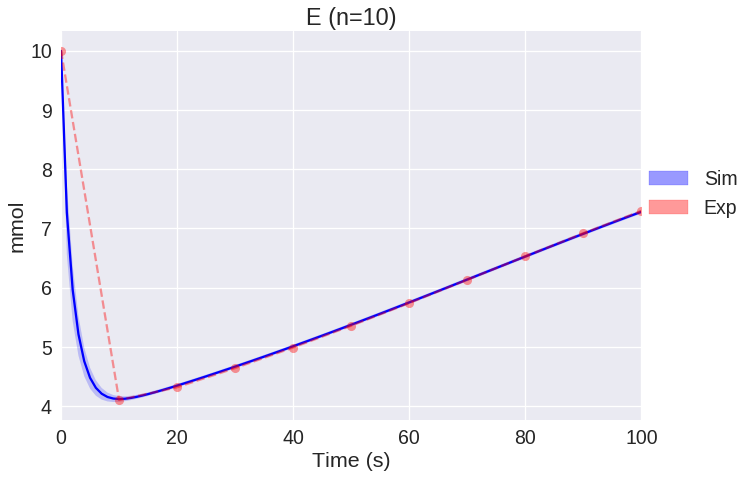

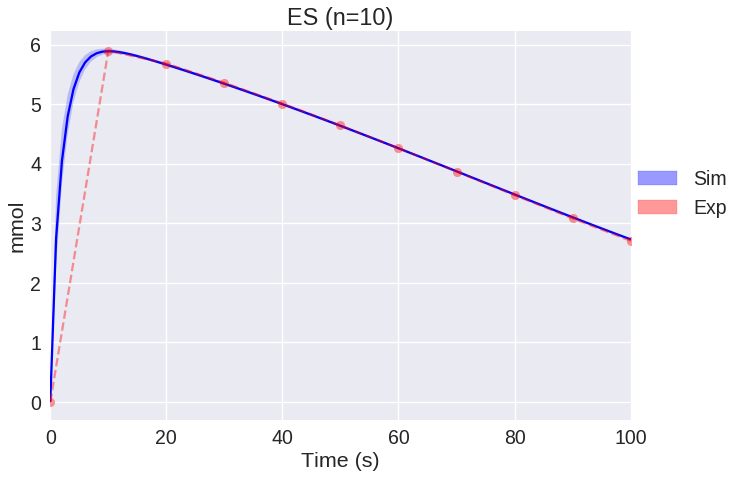

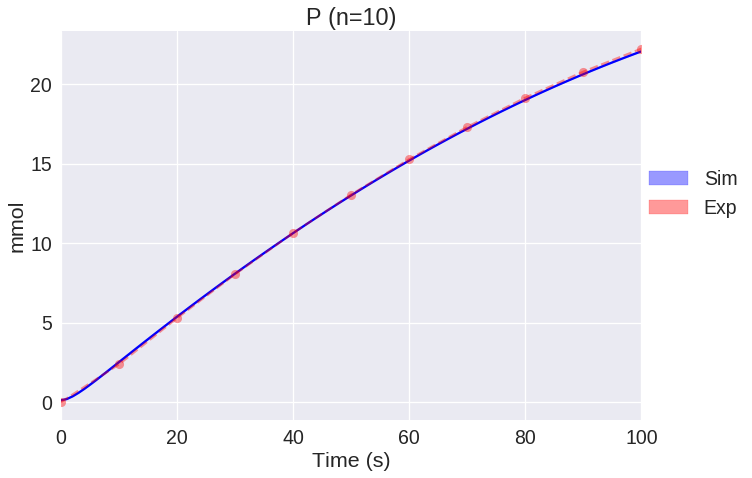

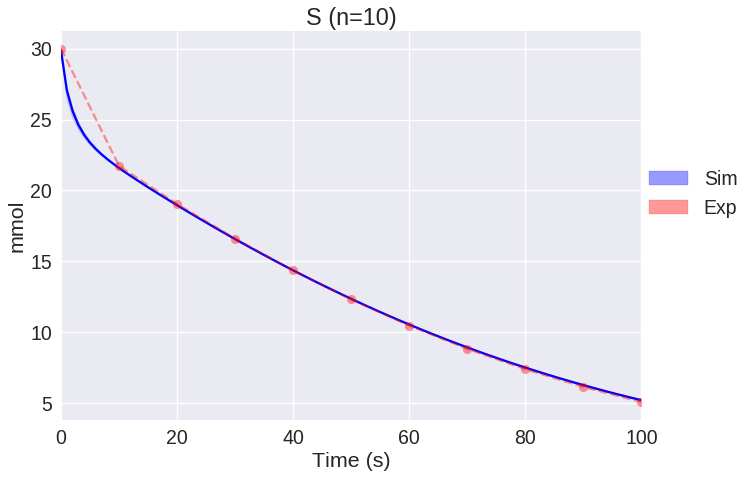

In [22]:
viz.PlotTimeCourseEnsemble(fit1, truncate_mode='ranks', theta=range(10))

Despite having correlated and imprecise parameter estimates it seems the fits are reasonable

### Profile Likelihoods

#### Run Local Chaser Estimation
First we ensure the best parameter set is at an actual minimum using Hooke and Jeeves - a deterministic parameter estimation algorithm which should produce the same result on each iteration. Despite this, here we use the MultiParameterEstimation class becuase it puts the results in a folder which can subsequently be used as argument to ProfileLikelihood. 

In [41]:
michaelis_menten.insert_parameters(parameter_path=fit1.results_directory, index=0)
fit1_2 = tasks.MultiParameterEstimation(michaelis_menten, TC.report_name, method='hooke_jeeves', 
                                      tolerance=1e-10, iteration_limit=300, 
                                      randomize_start_values=False, overwrite_config_file=True, 
                                      lower_bound=1e-3, upper_bound=5e3, 
                                      copy_number=2, pe_number=1, results_directory='chaser_estimations')

fit1_2.write_config_file()
fit1_2.setup()
fit1_2.run()
# michaelis_menten.open()

pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)
pycotools.tasks:DEBUG:602:    running Model(name=Michaelis-Menten, time_unit=s, volume_unit=ml, quantity_unit=mmol)


#### Run Profile Likelihoods

In [45]:
PL = tasks.ProfileLikelihood(michaelis_menten, parameter_path=fit1_2.results_directory, 
                        log10=True, index=[0], intervals=10, run=True, results_directory='fit1_profile_likelihoods',
                        max_active=2, iteration_limit=1000, tolerance=1e-15)

pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S bind E).kf.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(ES produce P).kcat.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/P.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/S.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S unbind E).kb.cps
pycotools.tasks:INFO:4866:    running /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES.cps


#### Plot  Profile Likelihoods
We can plot regular profile likelihoods. By default all profiles are plotted against RSS on the y axis. 

pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(ES produce P).kcat/RSS.png
pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S bind E).kf/RSS.png
pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S unbind E).kb/RSS.png
pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/E/RSS.png
pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/ES/RSS.png
pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/P/RSS.png
pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWor

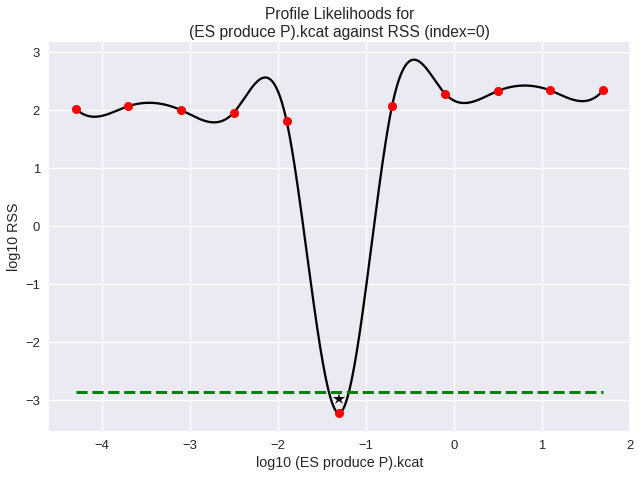

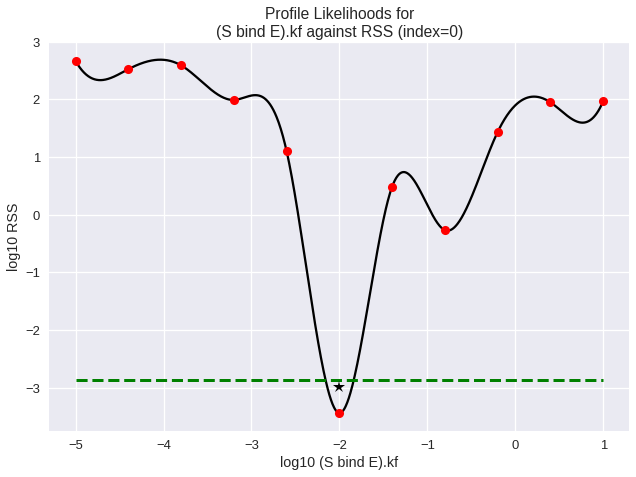

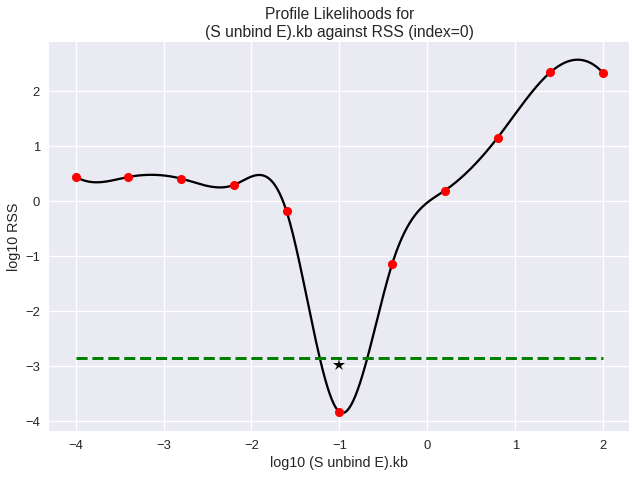

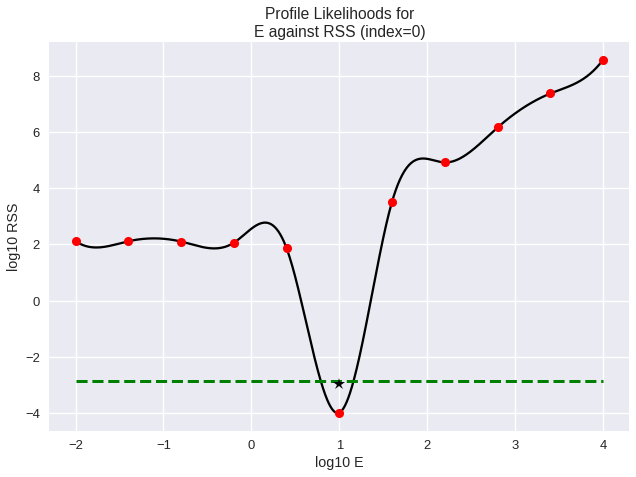

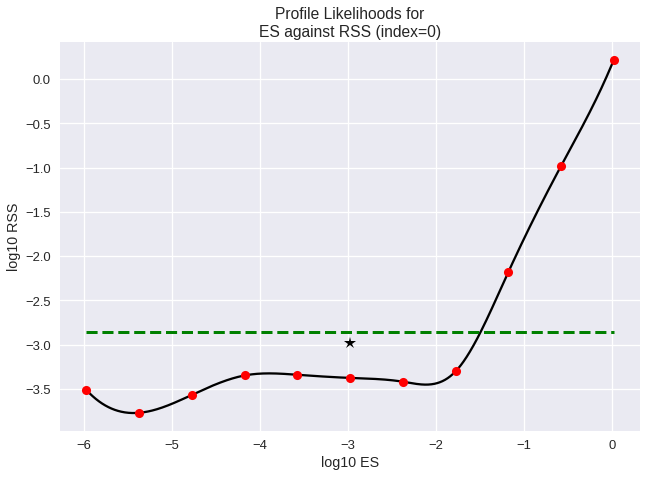

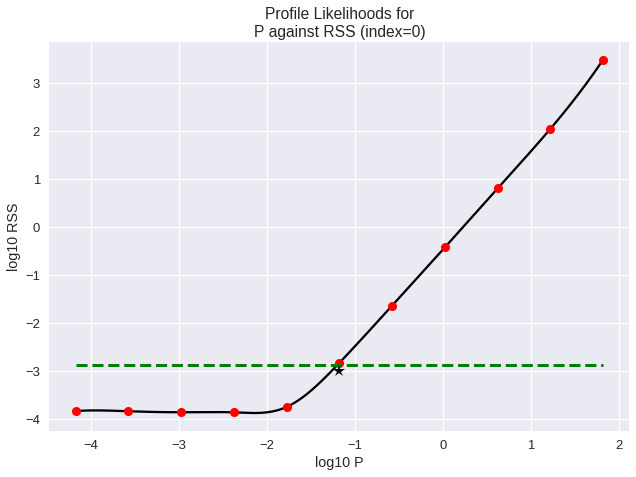

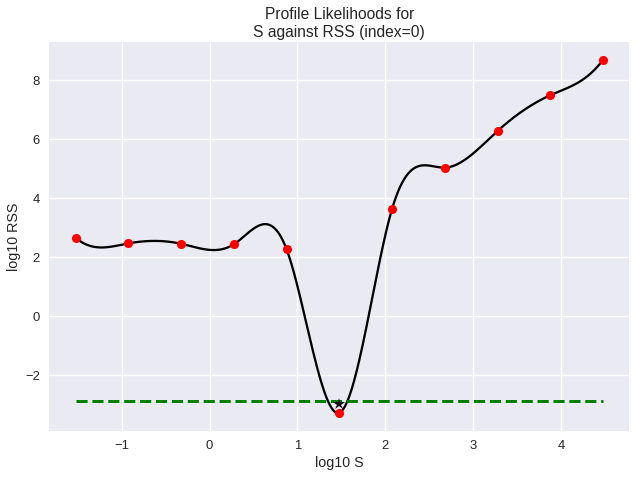

In [55]:
viz.PlotProfileLikelihood(PL, interpolation='cubic', savefig=True)

From these plots, it appears that both the initial concentrations of `ES` and `P` are practically non-identifiable. Given that these species have an initial concentration of 0 in the model, we could set these to 0 and not estimate them. 

One should also be aware that the settings used to calculate the profile likelihood will affect the profiles. Generally, it is better to set stringest algorithm settings (i.e. tolerance and iteration limit for Hooke and Jeeves) since we want to find the best possible RSS at each stage of the profile likelihood. Suboptimal settings and starting from a suboptimal parameter set can result in noisy profiles.
 
We can plot any variable on either axis to see if we can find avenues for model reduction, as in [Maiwold et, al., 2016](https://doi.org/10.1371/journal.pone.0162366). The obvious candidate for a relationship based on the scatter graphs from earlier is the `kf` versus `kb` parameters, i.e. where the enzyme binds or unbinds to substrate. To plot all variables against all other variables, set the `x` and `y` arguments to `'all`' in `viz.PlotProfileLikelihood`. Here however, we only look at the relationship between `kf` and `kb`. 

pycotools.viz:INFO:3590:    saved to --> /home/b3053674/Documents/Models/2017/12_Dec/PycotoolsWorkflowDir/fit1_profile_likelihoods/0/(S bind E).kf/(S unbind E).kb.png


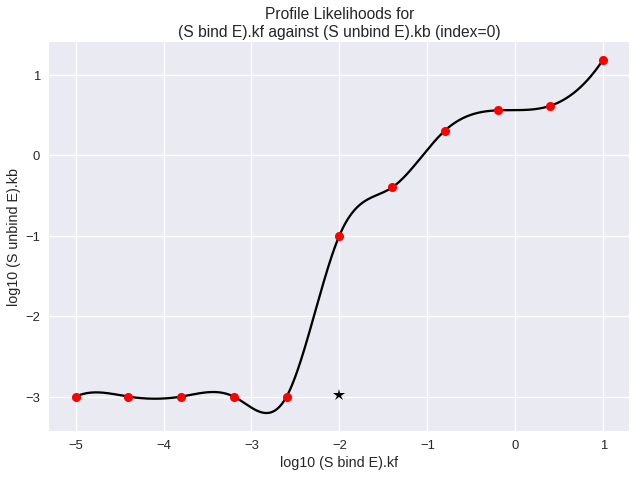

In [57]:
viz.PlotProfileLikelihood(PL, interpolation='cubic',x=['(S bind E).kf'], y= ['(S unbind E).kb'], savefig=True)

##### Interpretation
A few things to note:
    
    1) As kb increases, so does kf. 
    2) The profile does not extend past 1e-3 because this is the boundary of the optimization problem
    3) The profile here is not completely linear
    4) Since the black stars marking the RSS of `best parameter set` doesn't align with the corresponding point on the profile, the best estimated parameter set is close but not optimal.


If the profile was linear we could fit a linear curve and replace the kb parameter with a function in terms of kf (or vice versa). It is possible that a completely linear relationship would manafest between kf and kb if the profiles were calculated around the exact minima, though this remains to be tested.

### Summary

#### Optimization performance

    * Not the best performing algorithm because of a lack of step-like shape on the Likelihood ranks plot. 
    
#### Trajectories
    
    * All data fits the profiles reasonably well 
    
#### Distributions
    
    * Boxplots give good overview. E, S and Kcat parameters are well defined by the parameter estimation and have tight parameter distributions. Histograms verify these and suggest the estimates are normally distributed around the best parameter values. 
    * Other parameters are less well defined. It might be that the model is simply less sensitive to these parameters 
    
#### Correlations
Two relationships are linearly correlated with a high degree of statistical significance

    * (S bind E).kf and (S unbind E).kb have an $r^2$ of 0.9999 (p-value = 8.77e-102)
    * E and ES have a $r^2$ of -0.89 (p-value = 4.83e-15)
    
#### Profile Likelihoods

Despite some parameters having distribution spaning multiple orders of magnitude (boxplots), all but P and ES parameter are identifiable. Incidently these parameters are both 0 in the original model which is very difficult to estimate. 


### Modifications for Fit2
The information ascertained in the first round of parameter estimations can be used to refine the optimization problem for subsequent rounds. For example, we know that ES being an intermediate species could start as 0 and P being a product could also start as 0. Therefore we could set these to 0 and not estimate them to resolve the two non-identifiabilities. This additionally resolves the E Vs ES correlation since the ES parameter would be fixed to 0.

### Best parameters Versus True Parameters
 * kf = 0.01
 * kb = 0.1
 * kcat = 0.05
 * S = 30
 * E = 10
 * ES = 0
 * P = 0
 

In [29]:
viz.Parse(fit1).data.iloc[0]

E                       9.999950
ES                      0.009395
P                       0.001723
S                      29.899600
(ES produce P).kcat     0.049285
(S bind E).kf           0.013162
(S unbind E).kb         0.146519
RSS                     0.021981
Name: 0, dtype: float64